In [1]:
import pennylane as qml
from pennylane import AdamOptimizer
import pennylane.numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
dev = qml.device("lightning.qubit")

In [3]:
n_qubits = 2
n_layers = 2
shape_weights = (n_layers, n_qubits, 3)
weights_init = 0.01 * np.random.randn(n_layers,n_qubits,3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [4]:
def layer(weights_da_camada):
    for i in range(n_qubits):
        qml.RY(weights_da_camada[i, 1], wires=i)

    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

    for i in range(n_qubits):
        qml.RY(weights_da_camada[i, 1], wires=i)


@qml.qnode(dev)
def circuito(weights, x):
    qml.AmplitudeEmbedding(
        features=x,
        wires=range(n_qubits),
        pad_with=0.0,
        normalize=True
    )

    for layer_w in weights:
        layer(layer_w)

    return qml.expval(qml.PauliZ(0))


In [5]:
def cost(weights, bias, X, Y):
    raw_preds = [circuito(weights, x) + bias for x in X]
    predictions = qml.math.stack(raw_preds)

    probs = 1 / (1 + qml.math.exp(-predictions))

    loss = -qml.math.mean(
        Y * qml.math.log(probs + 1e-7)
        + (1 - Y) * qml.math.log(1 - probs + 1e-7)
    )
    return loss


In [6]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In [7]:
opt = qml.AdamOptimizer(0.01)

In [8]:
from sklearn.datasets import make_blobs
X, y = make_blobs(
    n_samples=500,
    centers=2,
    n_features=2,
    cluster_std=2.0,
    random_state=42
)


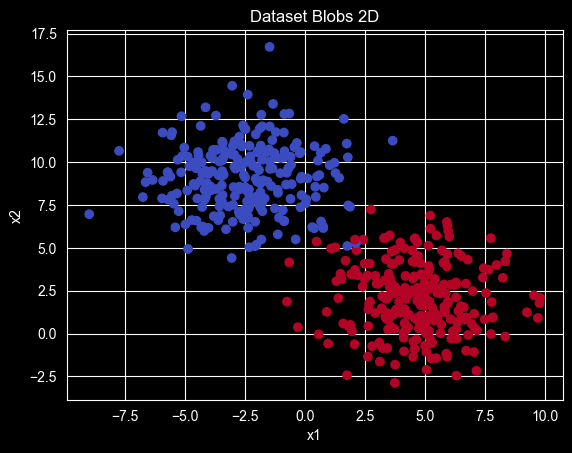

In [9]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Dataset Blobs 2D")
plt.show()


In [10]:
def pad_features(X):
    X_pad = np.zeros((X.shape[0], 4))
    X_pad[:, :2] = X
    return X_pad

X_pad = pad_features(X)
X_pad = X_pad / np.linalg.norm(X_pad, axis=1, keepdims=True)
y = y.astype(float)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_pad, y, test_size=0.2, random_state=42
)


In [11]:
weights = weights_init
bias = bias_init
epochs = 100
batch_size = 400 # Exemplo
from tqdm import tqdm
pbar = tqdm(total=epochs, desc="Epoch")
for it in range(epochs):
    # Amostragem do Batch
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = y_train[batch_index]

    # Passo de Otimização
    # Note: passamos X e Y com as letras maiúsculas para bater com a def cost(..., X, Y)
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # --- OTIMIZAÇÃO DE LOGS ---
    # Só calcula a acurácia total a cada 10 passos para não travar o PC
    current_predictions = [np.sign(circuito(weights, x) + bias) for x in X_train]

    current_cost = cost(weights, bias, X_batch, Y_batch)

    acc = accuracy(y_train, current_predictions)
    pbar.update(1)
    pbar.set_postfix(loss=current_cost)

Epoch:   2%|▏         | 2/100 [00:13<11:07,  6.81s/it, loss=0.8013249216012511]C:\Users\jairo\PycharmProjects\laciq\.venv\Lib\site-packages\autograd\wrap_util.py:38: SyntaxWarning: 'return' in a 'finally' block
  return f


KeyboardInterrupt: 

In [ ]:
def predict_proba(X, weights, bias):
    raw = [circuito(weights, x) + bias for x in X]
    raw = qml.math.stack(raw)
    return 1 / (1 + qml.math.exp(-raw))
def predict(X, weights, bias):
    probs = predict_proba(X, weights, bias)
    return (probs >= 0.5).astype(int)
y_pred = predict(X_val, weights, bias)
acc = (y_pred == y_val).mean()

print(f"Acurácia validação: {acc:.3f}")


In [ ]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 150),
    np.linspace(y_min, y_max, 150)
)

grid_2d = np.c_[xx.ravel(), yy.ravel()]
grid_pad = np.zeros((grid_2d.shape[0], 4))
grid_pad[:, :2] = grid_2d

grid_pad = grid_pad / np.linalg.norm(grid_pad, axis=1, keepdims=True)
probs_grid = predict_proba(grid_pad, weights, bias)
Z = probs_grid.reshape(xx.shape)


In [ ]:

plt.figure(figsize=(7, 6))

plt.contourf(xx, yy, Z, levels=50, cmap="coolwarm", alpha=0.6)

plt.contour(xx, yy, Z, levels=[0.5], colors="black", linewidths=2)

plt.scatter(
    X[:, 0], X[:, 1],
    c=y,
    cmap="coolwarm",
    edgecolors="k"
)

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Fronteira de decisão do circuito quântico")
plt.show()
